In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.color_palette("husl", 10)
import missingno as msno

from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import DataConversionWarning
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
from warnings import filterwarnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from scipy.stats import mode
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

from xgboost import plot_importance
import shap

from fractions import Fraction
from string import ascii_letters

def frac_to_float(frac):
    try:
        if isinstance(frac, float):
            return frac
        if frac == "1 / 200s":
            frac = "1/200"
        return float(sum(Fraction(s.rstrip(ascii_letters)) for s in frac.split()))
    except:
        print(frac)

In [2]:
# Load/Preprocess data

train = pd.read_csv("data/train.csv")
train_colors = pd.read_csv("data/train_colors.csv")
train_keywords = pd.read_csv("data/train_keywords.csv")
test = pd.read_csv("data/test.csv")
test_colors = pd.read_csv("data/test_colors.csv")
test_keywords = pd.read_csv("data/test_keywords.csv")

cam_make_map = {
 "ASUS": "Asus", "Cannon": "Canon", 
 'Canon, SVR 90mm, 15 images': "Canon",
 'Canon, SVR90, 15 images': "Canon",
 'Canon, SVR90mm, 11 images': "Canon",
 'Canon, WOGT71, 19 images': "Canon",
 'Canon, WOGT71, 26 images': "Canon",
 'Canon, WOGT71, 32 images': "Canon",
 "canon": "Canon",
 'DJI Mavic 2 Pro': "DJI",
 'DJI Mavic Pro': "DJI",
 'DJI Spark': "DJI",
 'FUJIFILM': "Fujifilm",
 'FujiFilm': "Fujifilm",
 'Fujica': "Fujifilm",
 "google": "Google",
 'HASSELBLAD': "Hasselblad",
 "HUAWEI": "Huawei",
 'LEICA CAMERA AG': "LEICA",
 'Leica Camera AG': "LEICA",
 'LG Electronics': "LGE",
 'NIKON': "Nikon",
 'NIKON CORPORATION': "Nikon",
 'OLYMPUS CORPORATION': "Olympus",
 'OLYMPUS IMAGING CORP.': "Olympus",
 'PENTAX Corporation': "Pentax",
 'PENTAX RICOH IMAGING': "Pentax",
 "PENTAX": "Pentax",
 'RICOH IMAGING COMPANY, LTD.': "Ricoh",
 "SAMSUNG": "Samsung",
 "SONY": "Sony",
 "XIAOMI": "Xiaomi",
 'XIAOYI': "Xiaomi",
 'ZWO WOGT71': "ZWO",
 'ZWO w/ WOGT71 21 frames each SHO': "ZWO",
 'ZWO, WOGT71, 15 frames each of H, O, S': "ZWO",
 'motorola': "Motorola",
 "nikon": "Nikon",
 "olympus": "Olympus",
 "samsung": "Samsung",
 "sony": "Sony",
 }

train = train[(train["stats_downloads"] < 300000)]
train["image_category"] = train["image_category"].replace({"Featured": 1, "Not Featured": 0})
train["camera_make"] = train["camera_make"].replace(cam_make_map)
train["camera_make"] = train["camera_make"].apply(lambda x: str(x).lower())
make_counts = train["camera_make"].value_counts()

# Remove instances where camera_make <= 10
train = train[train["camera_make"].isin(make_counts[make_counts > 10].index)]
train["exposure_time"] = train["exposure_time"].apply(frac_to_float)
train["photo_submitted_at"] = pd.to_datetime(train["photo_submitted_at"])

# Fill Missing Values
train["aperture_value"] = train["aperture_value"].fillna(train["aperture_value"].mean())
train["iso"] = train["iso"].fillna(train["iso"].mean())
train["exposure_time"] = train["exposure_time"].fillna(train["exposure_time"].mean())

# Fill missing camera_make data based on camera_model data
make_replace_id = ["eca7e87d03", "bee68f9815", "5e15dcf061", "efd3bf77ec", "63cd2598c2", "759de7f18d", "8b215885c7", "c83069821b", "4bdba7914b", "913cc10182"]
make_replace_str = ["olympus", "nikon", "canon", "nikon", "nikon", "nikon", "canon", "sony", "olympus", "olympus"]
for replace_id, replace_str in zip(make_replace_id, make_replace_str):
    train.loc[train["image_id"] == replace_id, "camera_make"] = replace_str

# Drop unnecessary columns
train.drop(columns=["photo_url", "photo_image_url", "photo_submitted_at", "latitude", "longitude", "country", "city"], inplace=True)

# Drop columns for now
# train.drop(columns=["obs_hour", "obs_min", "obs_sec", "width", "height", "iso", "aperture_value", "focal_length", "exposure_time", "description1", "description2", "camera_model"], inplace=True)

# Day and hour may be important, keep aspect ratio because image dimensions make sense to affect download rates (if image is shaped too tall or wide it could be negative)

train_num = train.select_dtypes(include=np.number)
train

,image_id,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads
0,68105c019b,Thursday,15,13,10,1,2592,1728,1.500,Pristine water lily,rule of thirds photography of pink and white l...,canon,Canon EOS 60D,200.000,14.000,50.000,0.017,2361,167503
1,06d11c4edd,Wednesday,21,59,51,1,4000,6000,0.670,NaN,sand in desert,sony,ILCE-6500,100.000,2.500,30.000,0.001,1255,1839
2,f6599edba1,Tuesday,4,10,11,1,5504,8256,0.670,NaN,green trees near brown mountain during daytime,nikon,NIKON D850,64.000,2.800,48.000,0.001,1138,787
3,0f4bcc2d36,Monday,23,46,21,1,3627,2040,1.780,NaN,gray dock aerial photography,dji,FC220,139.000,2.200,4.700,0.010,1579,2049
4,74db502ed5,Saturday,11,4,20,1,4896,3264,1.500,NaN,people walking on green grass field near lake ...,fujifilm,X-T10,400.000,6.400,22.200,0.002,1050,2982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12192,18eaca644e,Monday,13,7,25,1,4480,6111,0.730,NaN,calm water during night time,canon,Canon EOS 5D Mark IV,100.000,5.600,300.000,0.003,1265,2353
12193,eb25cd769e,Monday,20,32,28,1,2403,3337,0.720,NaN,snowflakes on ground,canon,Canon EOS 5D Mark III,400.000,5.000,100.000,0.003,1503,3541
12194,73302461d0,Thursday,1,54,16,1,5184,3456,1.500,Inside of the small wave,NaN,canon,Canon EOS M,400.000,4.000,21.000,0.000,2501,14581
12195,f2587b2b08,Thursday,18,2,32,1,6000,4000,1.500,Tropical palm,low angle of banana tree,nikon,NIKON D5300,800.000,1.800,50.000,0.003,2508,9247


In [3]:
# test = test[(test["stats_downloads"] < 300000)]
test["image_category"] = test["image_category"].replace({"Featured": 1, "Not Featured": 0})
test["camera_make"] = test["camera_make"].replace(cam_make_map)
test["camera_make"] = test["camera_make"].apply(lambda x: str(x).lower())

test["exposure_time"] = test["exposure_time"].apply(frac_to_float)
test["photo_submitted_at"] = pd.to_datetime(test["photo_submitted_at"])

# Fill Missing Values
test["aperture_value"] = test["aperture_value"].fillna(test["aperture_value"].mean())
test["iso"] = test["iso"].fillna(test["iso"].mean())
test["exposure_time"] = test["exposure_time"].fillna(test["exposure_time"].mean())

# Fill missing camera_make data based on camera_model data
# make_replace_id = ["eca7e87d03", "bee68f9815", "5e15dcf061", "efd3bf77ec", "63cd2598c2", "759de7f18d", "8b215885c7", "c83069821b", "4bdba7914b", "913cc10182"]
# make_replace_str = ["olympus", "nikon", "canon", "nikon", "nikon", "nikon", "canon", "sony", "olympus", "olympus"]
# for replace_id, replace_str in zip(make_replace_id, make_replace_str):
#     test.loc[test["image_id"] == replace_id, "camera_make"] = replace_str

# Drop unnecessary columns
test.drop(columns=["photo_url", "photo_image_url", "photo_submitted_at", "obs_min", "obs_sec", "width", "height", "iso", "aperture_value", "focal_length", "exposure_time", "latitude", "longitude", "country", "city"], inplace=True)

# Day and hour may be important, keep aspect ratio because image dimensions make sense to affect download rates (if image is shaped too tall or wide it could be negative)

test_num = test.select_dtypes(include=np.number)
test

63 Seconds
30"


,image_id,obs_day,obs_hour,image_category,aspect_ratio,description1,description2,camera_make,camera_model,total_days
0,2322208d63,Wednesday,14,1,0.670,NaN,brown leaf,nikon,NIKON D750,1249
1,847b5fcee1,Saturday,17,1,1.500,NaN,gray seal,canon,Canon EOS 6D Mark II,1211
2,0e1a37b065,Tuesday,6,1,1.500,NaN,NaN,canon,Canon EOS 6D,1439
3,8c8c9d4355,Tuesday,14,1,0.670,NaN,landscape photography of desert,sony,ILCE-7M2,1194
4,8ff19c3747,Friday,1,1,1.500,NaN,brown grass,sony,ILCE-6000,1457
...,...,...,...,...,...,...,...,...,...,...
6563,a41cfba199,Tuesday,10,1,0.770,NaN,woman fixing flowers in pot,canon,Canon EOS 650D,1285
6564,73bbb77964,Monday,10,1,0.710,Autumn vibes,brown mushroom in ground,sony,ILCE-7RM2,1258
6565,22028b67b0,Sunday,16,1,0.670,NaN,NaN,canon,Canon EOS R,1315
6566,7abf54e623,Monday,19,1,0.670,"Hat in a car. Saw it in Klagenfurt, Austria",white and black hat,fujifilm,X-T1,1426


In [4]:
test_data = test.select_dtypes(include=np.number)
test_data

,obs_hour,image_category,aspect_ratio,total_days
0,14,1,0.670,1249
1,17,1,1.500,1211
2,6,1,1.500,1439
3,14,1,0.670,1194
4,1,1,1.500,1457
...,...,...,...,...
6563,10,1,0.770,1285
6564,10,1,0.710,1258
6565,16,1,0.670,1315
6566,19,1,0.670,1426


In [ ]:
test.dtypes

In [ ]:
test.isnull().sum()

In [ ]:
# len(train[train["camera_make"] == "nan"])
len(train[train["camera_make"] == "nan"])

In [ ]:
train.dtypes

In [ ]:
train.isnull().sum()

In [5]:
make = []
counts = []
avg_downloads = []
for group, data in train.groupby("camera_make"):
    make.append(group)
    counts.append(len(data))
    avg_downloads.append(data["stats_downloads"].mean())
make_downloads = pd.DataFrame({"make": make, "count": counts, "avg_downloads": avg_downloads})

In [129]:
popular_high_downloads = make_downloads[(make_downloads["count"] > 100) & (make_downloads["avg_downloads"] > 9000)]
popular_high_downloads
# Idea, create new column, 1 if camera make is in this list

,make,count,avg_downloads
0,apple,318,12371.437
1,canon,4857,9511.060
2,dji,452,9626.885
3,fujifilm,854,10541.172
10,nikon,2643,10241.479
11,olympus,168,12517.738
12,panasonic,264,10405.326


In [130]:
popular_high_downloads.make

0         apple
1         canon
2           dji
3      fujifilm
10        nikon
11      olympus
12    panasonic
Name: make, dtype: object

In [7]:
days = []
counts = []
avg_downloads = []
for group, data in train.groupby("obs_day"):
    days.append(group)
    counts.append(len(data))
    avg_downloads.append(data["stats_downloads"].mean())
day_downloads = pd.DataFrame({"day": days, "count": counts, "avg_downloads": avg_downloads})
day_downloads.sort_values(["count", "avg_downloads"], ascending=False, inplace=True)
day_downloads.reset_index(drop=True, inplace=True)
day_downloads

# Seems to be some correlation between day and downloads

,day,count,avg_downloads
0,Monday,2030,9997.781
1,Wednesday,1867,9740.711
2,Tuesday,1826,10266.800
3,Thursday,1739,9725.454
4,Friday,1692,9071.952
5,Sunday,1582,8684.551
6,Saturday,1385,8912.731


In [ ]:
# train[train["camera_model"].isnull()].index
train[train["camera_make"] == "nan"]

# make_replace_id = ["eca7e87d03", "bee68f9815", "5e15dcf061", "efd3bf77ec", "63cd2598c2", "759de7f18d", "8b215885c7", "c83069821b", "4bdba7914b", "913cc10182"]
# make_replace_str = ["olympus", "nikon", "canon", "nikon", "nikon", "nikon", "canon", "sony", "olympus", "olympus"]

<Axes: >

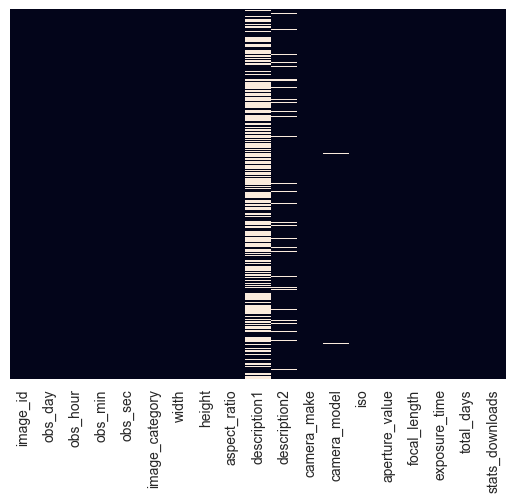

In [8]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False)

In [ ]:
train.info()

In [ ]:
train["description2"].value_counts()

In [9]:
train[train["camera_model"].isnull()]

,image_id,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,description1,description2,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads
676,9a12bb8fe9,Wednesday,11,55,56,1,3992,2992,1.330,Wild Blues 🌊,bird's-eye photography of body of water,dji,NaN,200.000,2.200,4.790,0.013,1459,2977
2286,5aaa9a4bde,Monday,19,26,32,1,4096,2734,1.500,NaN,brown and green grass field during sunset,nan,NaN,50.000,2.800,20.000,0.001,1419,1372
2612,63c0ba214e,Monday,19,52,50,1,2412,4288,0.560,NaN,scenery of forest trees,nikon,NaN,160.000,3.500,50.000,0.004,1937,167386
2737,90bd79188c,Monday,20,48,44,1,4004,2669,1.500,NaN,brown antelope,canon,NaN,1000.000,5.600,400.000,0.005,1363,2911
3134,2618e3780c,Sunday,0,31,35,1,4160,3120,1.330,NaN,two boat on body of water,nan,NaN,101.000,2.000,3.800,0.001,2519,8984
3333,aba93959bc,Wednesday,3,52,9,1,2731,4096,0.670,Pier with water splashing at sunset,brown wooden dock on sea during daytime,nan,NaN,200.000,2.500,35.000,0.002,1144,887
3961,28e7a4e710,Wednesday,9,31,18,1,4553,5691,0.800,Blue ambiance in the forest,green trees on foggy weather,nan,NaN,100.000,5.000,10.300,0.005,1025,4876
4018,454bb547b6,Monday,13,48,53,1,5280,4227,1.250,A forest in the snow,withered trees surrounded by snow,nan,NaN,200.000,7.100,19.200,0.017,2616,20051
4028,8034cf0628,Sunday,16,46,43,1,3240,2160,1.500,Football on Faroe islands #4,women's white shirt,nan,NaN,100.000,3.200,55.000,0.001,1343,2599
4145,629b45abeb,Tuesday,8,6,20,1,5304,7952,0.670,Butterfly on Leaf,brown and black butterfly on white flower,nan,NaN,100.000,2.000,25.000,0.006,1096,14598


In [ ]:
# Categorical: obs_day, camera_make, camera_model
make_counts = train["camera_make"].value_counts()
make_counts
# make_counts[make_counts > 10].index

In [ ]:
train.describe()

In [ ]:
train[train.exposure_time < 1000]

In [ ]:
sns.distplot(train["stats_downloads"])

In [ ]:
sns.distplot(np.log1p(train["stats_downloads"]))

In [ ]:
corrs = []
for col in train_num.columns[:-1]:
    corr = train[col].corr(train["stats_downloads"])
    corrs.append(corr)
    # print(f"Column {col}: {corr}")

corr_df = pd.DataFrame({"col": train_num.columns[:-1], "corr": corrs})
corr_df.sort_values("corr", ascending=False)

# total_days is strongest predictor

# Initial Findings/Ideas

## Findings
* "total_days" is most highly correlated with "stats_downloads"

## Ideas
* Day of the week, time of day effect on downloads
* If image_category = "Not Featured", very low downloads

<Axes: >

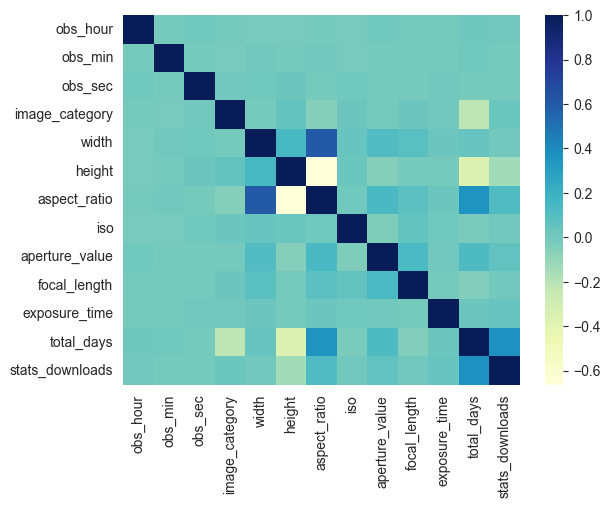

In [10]:
sns.heatmap(train_num.corr(), cmap="YlGnBu")

<Axes: >

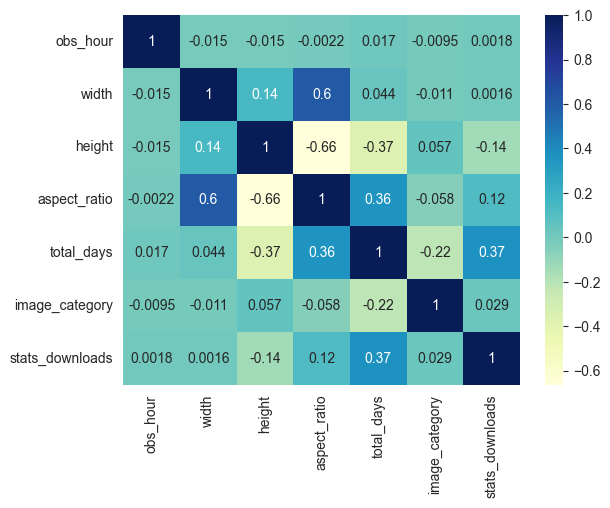

In [11]:
train_sub = train[["obs_hour", "width", "height", "aspect_ratio", "total_days", "image_category", "stats_downloads"]]
sns.heatmap(data=train_sub.corr(), cmap="YlGnBu", annot=True)

In [ ]:
train_num.columns

In [ ]:
# Columns to drop
to_drop = ['obs_hour', 'obs_min', 'obs_sec', 'width', 'height', 'iso', 'aperture_value', 'focal_length', 'latitude',
       'longitude', 'total_days', 'stats_downloads']

In [ ]:
train.dtypes

In [ ]:
sns.regplot(x="total_days", y="stats_downloads", color="navy", data=train)

In [ ]:
sns.regplot(x="exposure_time", y="stats_downloads", data=train[train.exposure_time < 2000])

In [ ]:
sns.regplot(x="aspect_ratio", y="stats_downloads", data=train)

In [ ]:
sns.regplot(x="total_days", y="height", color="navy", data=train)

In [ ]:
sns.regplot(x="total_days", y="aspect_ratio", color="navy", data=train)

In [ ]:
sns.regplot(x="height", y="stats_downloads", data=train)

In [ ]:
sns.regplot(x="obs_hour", y="stats_downloads", data=train)

In [12]:
# train_encoded = pd.get_dummies(train, columns=["obs_day", "camera_make"])
# train_encoded = pd.get_dummies(train, columns=["camera_make"])
# train_encoded = pd.get_dummies(train, columns=["obs_day"])
train_encoded = train.select_dtypes(include=np.number)
train_encoded

,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads
0,15,13,10,1,2592,1728,1.500,200.000,14.000,50.000,0.017,2361,167503
1,21,59,51,1,4000,6000,0.670,100.000,2.500,30.000,0.001,1255,1839
2,4,10,11,1,5504,8256,0.670,64.000,2.800,48.000,0.001,1138,787
3,23,46,21,1,3627,2040,1.780,139.000,2.200,4.700,0.010,1579,2049
4,11,4,20,1,4896,3264,1.500,400.000,6.400,22.200,0.002,1050,2982
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12192,13,7,25,1,4480,6111,0.730,100.000,5.600,300.000,0.003,1265,2353
12193,20,32,28,1,2403,3337,0.720,400.000,5.000,100.000,0.003,1503,3541
12194,1,54,16,1,5184,3456,1.500,400.000,4.000,21.000,0.000,2501,14581
12195,18,2,32,1,6000,4000,1.500,800.000,1.800,50.000,0.003,2508,9247


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Initial XGBoost testing
data = train_encoded.select_dtypes(include=np.number)
X = data.drop(columns="stats_downloads")
y = data["stats_downloads"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=8)

In [56]:
X

,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,iso,aperture_value,focal_length,exposure_time,total_days
0,15,13,10,1,2592,1728,1.500,200.000,14.000,50.000,0.017,2361
1,21,59,51,1,4000,6000,0.670,100.000,2.500,30.000,0.001,1255
2,4,10,11,1,5504,8256,0.670,64.000,2.800,48.000,0.001,1138
3,23,46,21,1,3627,2040,1.780,139.000,2.200,4.700,0.010,1579
4,11,4,20,1,4896,3264,1.500,400.000,6.400,22.200,0.002,1050
...,...,...,...,...,...,...,...,...,...,...,...,...
12192,13,7,25,1,4480,6111,0.730,100.000,5.600,300.000,0.003,1265
12193,20,32,28,1,2403,3337,0.720,400.000,5.000,100.000,0.003,1503
12194,1,54,16,1,5184,3456,1.500,400.000,4.000,21.000,0.000,2501
12195,18,2,32,1,6000,4000,1.500,800.000,1.800,50.000,0.003,2508


In [ ]:
"""
PERFORMANCE LOG:
xgb = XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=0.8255063664935096,
                              colsample_bynode=0.9566459979367115,
                              colsample_bytree=0.7745652753956729,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=9.034580483401264, gpu_id=-1,
                              grow_policy=None,
                              interaction_constraints='',
                              learning_rate=0.02796171154881776, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=np.nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=8,
                              reg_alpha=0.7365325308038474,
                              reg_lambda=2.3562893513108114)

Columns: 
RMSE: 21721.256295668343
opt.best_score_: -20802.16068150209
opt.score(X, y): -20402.938553502623
TEST: 31170.67550

################# BEST ##################
xgb = XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=0.5, colsample_bynode=0.5,
                              colsample_bytree=1.0, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0.0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.06416530723807765, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=np.nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=8, reg_alpha=0.0,
                              reg_lambda=10.0,)

Columns: X_subset = X[total_importance.feature[:7]]
RMSE: 21702.810565393305
opt.best_score_: -20705.163702804275
opt.score(X, y): -19245.209958432722
TEST: 30822.13104
"""

In [16]:
# use feature importance for feature selection
from sklearn.feature_selection import SelectFromModel
from numpy import sort

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
# fit model on all training data
model = XGBRegressor()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBRegressor()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	# predictions = [round(value) for value in y_pred]
	rmse = np.sqrt(mean_squared_error(y_test, y_pred))
	print(["-"]*20)
	# print(select_X_test.columns)
	print(f"Thresh: {thresh}, n={select_X_train.shape[1]}, RMSE: {rmse}")
	

RMSE: 22863.652163838553
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
Thresh: 0.033741291612386703, n=12, RMSE: 22863.652163838553
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
Thresh: 0.05007892847061157, n=11, RMSE: 23213.70754489629
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
Thresh: 0.05016016215085983, n=10, RMSE: 22872.008201878187
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
Thresh: 0.05435323715209961, n=9, RMSE: 22645.937272588846
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
Thresh: 0.056233249604701996, n=8, RMSE: 22829.040341463802
['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
Thresh: 0.06352005898952484, n=7, RMSE: 23027.204249567352
['-', '-', 

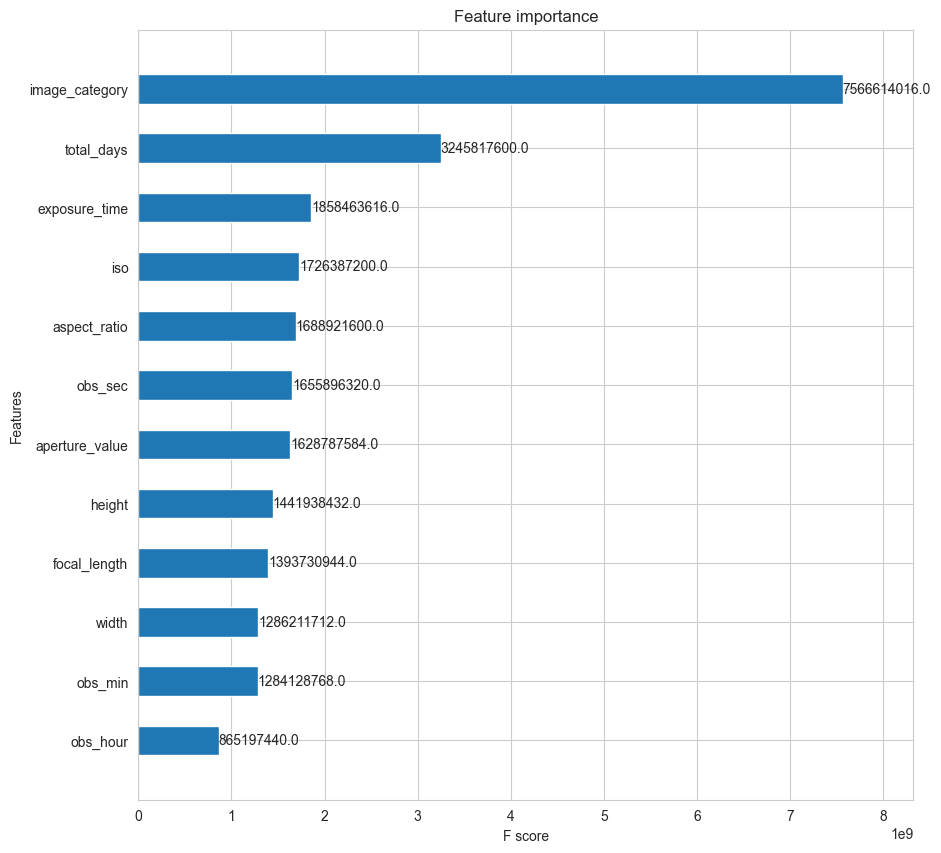

In [17]:
# Gain : The average loss reduction gained when using this feature for splitting in trees
fig, ax = plt.subplots(figsize=(10,10))
plot_importance(model, max_num_features=50, height=0.5, ax=ax,importance_type='gain')
plt.show()

In [46]:
gain = ["image_category", "total_days", "exposure_time", "iso", "aspect_ratio", "obs_sec", "aperture_value", "height", "focal_length", "width", "obs_min", "obs_hour"]
weight = ["total_days", "obs_hour", "obs_min", "width", "obs_sec", "height", "focal_length", "exposure_time", "aperture_value", "iso", "aspect_ratio", "image_category"]
cover = ["image_category", "total_days", "aspect_ratio", "height", "exposure_time", "width",  "focal_length", "iso", "aperture_value", "obs_min", "obs_sec", "obs_hour"]

In [47]:
importance_df = pd.DataFrame({"gain": gain, "weight":weight, "cover":cover})
# importance_df.index = importance_df.index.astype(int)
importance_df

,gain,weight,cover
0,image_category,total_days,image_category
1,total_days,obs_hour,total_days
2,exposure_time,obs_min,aspect_ratio
3,iso,width,height
4,aspect_ratio,obs_sec,exposure_time
5,obs_sec,height,width
6,aperture_value,focal_length,focal_length
7,height,exposure_time,iso
8,focal_length,aperture_value,aperture_value
9,width,iso,obs_min


In [48]:
importance_df[importance_df["gain"] == "iso"].index[0]

3

In [52]:
sum_index = []
for feature in gain:
    total = 0
    for measure in ["gain", "weight", "cover"]:
        try:
            total += importance_df[importance_df[measure] == feature].index[0]
        except:
            print(f"{feature}, {measure}")
    sum_index.append(total)
total_importance = pd.DataFrame({"feature": gain, "rank": sum_index})
total_importance.sort_values("rank", inplace=True)
total_importance.reset_index(drop=True)

,feature,rank
0,total_days,2
1,image_category,11
2,exposure_time,13
3,height,15
4,aspect_ratio,16
5,width,17
6,iso,19
7,obs_sec,19
8,focal_length,20
9,obs_min,21


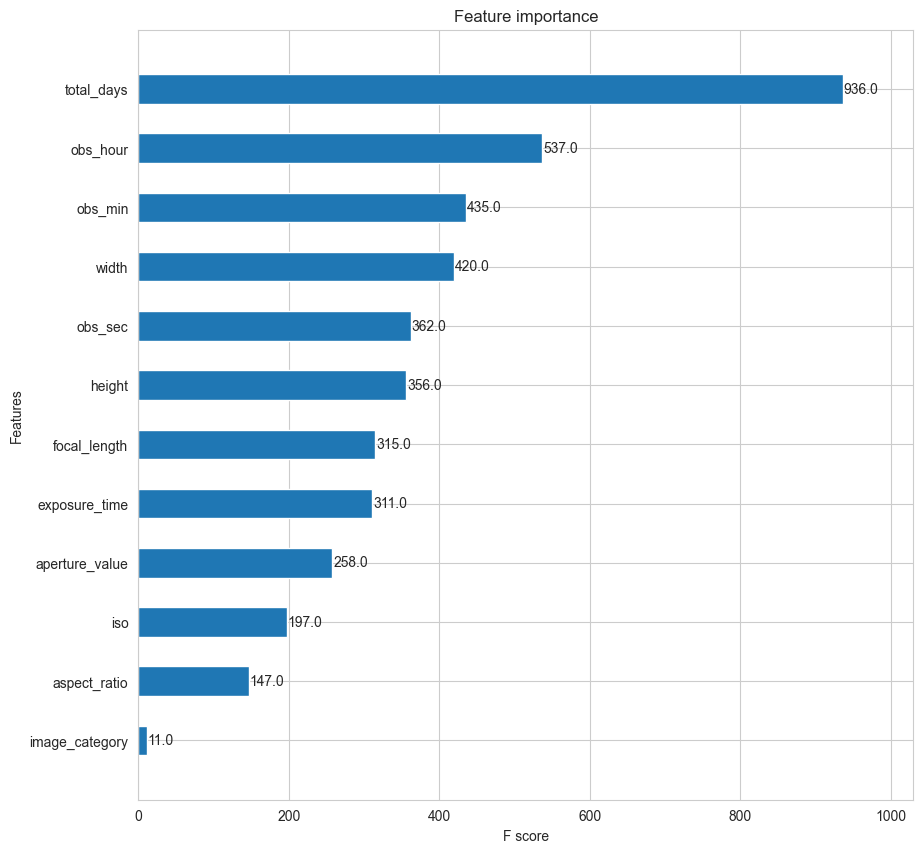

In [18]:
# weight : The total number of times this feature was used to split the data across all trees
fig, ax = plt.subplots(figsize=(10,10))
plot_importance(model, max_num_features=50, height=0.5, ax=ax,importance_type='weight')
plt.show()

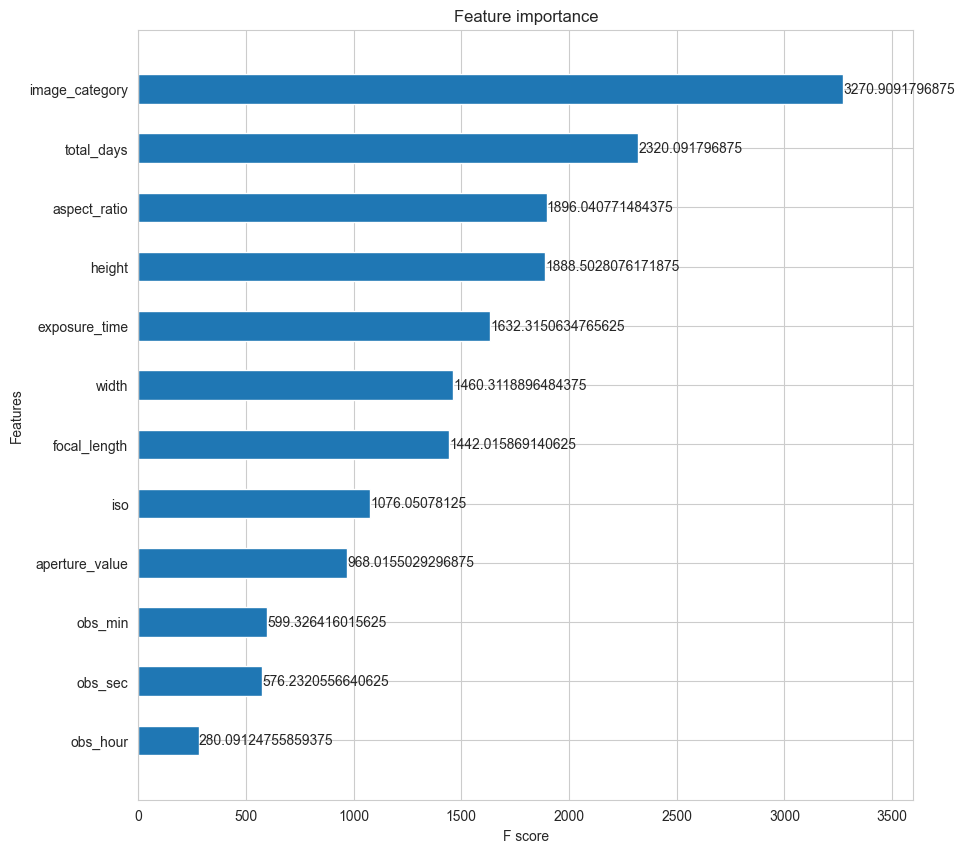

In [19]:
# Cover : The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
fig, ax = plt.subplots(figsize=(10,10))
plot_importance(model, max_num_features=50, height=0.5, ax=ax,importance_type='cover')
plt.show()

In [135]:
popular_high_downloads

,make,count,avg_downloads
0,apple,318,12371.437
1,canon,4857,9511.060
2,dji,452,9626.885
3,fujifilm,854,10541.172
10,nikon,2643,10241.479
11,olympus,168,12517.738
12,panasonic,264,10405.326


In [134]:
train["camera_make"].isin(popular_high_downloads.make).astype(int)
train["camera_make"]

0           canon
1            sony
2           nikon
3             dji
4        fujifilm
           ...   
12192       canon
12193       canon
12194       canon
12195       nikon
12196       canon
Name: camera_make, Length: 12121, dtype: object

In [140]:
X_subset = X[total_importance.feature[:7]]
X_subset["popular_make"] = train["camera_make"].isin(popular_high_downloads.make).astype(int)
# X_subset = pd.concat([X_subset, pd.get_dummies(train[["obs_day", "camera_make"]])], axis=1)
# X_subset = pd.concat([X_subset, pd.get_dummies(train[["obs_day"]])], axis=1)
# X_subset = pd.concat([X_subset, pd.get_dummies(train[["camera_make"]])], axis=1)
# X_subset = X[['total_days', 'image_category', 'exposure_time', 'height', 'aspect_ratio', 'width', 'iso', 'obs_sec', 'focal_length', 'obs_min']]
X_subset

,total_days,image_category,exposure_time,height,aspect_ratio,width,iso,popular_make
0,2361,1,0.017,1728,1.500,2592,200.000,1
1,1255,1,0.001,6000,0.670,4000,100.000,0
2,1138,1,0.001,8256,0.670,5504,64.000,1
3,1579,1,0.010,2040,1.780,3627,139.000,1
4,1050,1,0.002,3264,1.500,4896,400.000,1
...,...,...,...,...,...,...,...,...
12192,1265,1,0.003,6111,0.730,4480,100.000,1
12193,1503,1,0.003,3337,0.720,2403,400.000,1
12194,2501,1,0.000,3456,1.500,5184,400.000,1
12195,2508,1,0.003,4000,1.500,6000,800.000,1


In [142]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

estimators = [
    # ('encoder', TargetEncoder()),
    ('regr', XGBRegressor(random_state=8)) # can customize objective function with the objective parameter
]
pipe = Pipeline(steps=estimators)

search_space = {
    # 'regr__max_depth': Integer(2,8),
    'regr__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'regr__subsample': Real(0.5, 1.0),
    'regr__colsample_bytree': Real(0.5, 1.0),
    'regr__colsample_bylevel': Real(0.5, 1.0),
    'regr__colsample_bynode' : Real(0.5, 1.0),
    'regr__reg_alpha': Real(0.0, 10.0),
    'regr__reg_lambda': Real(0.0, 10.0),
    'regr__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=10, scoring='neg_root_mean_squared_error', random_state=8) 
opt.fit(X_subset, y)
# in reality, you may consider setting cv and n_iter to higher values

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('regr',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=...
                             'regr__gamma': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'regr__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'regr__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'regr__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'regr__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [143]:
opt.best_estimator_

Pipeline(steps=[('regr',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=0.8255063664935096,
                              colsample_bynode=0.9566459979367115,
                              colsample_bytree=0.7745652753956729,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=9.034580483401264,
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.02796171154881776, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=None,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=8, ...))])

In [144]:
opt.best_score_

-20723.4170116747

In [123]:
opt.score(X_subset, y)

-20123.253615456888

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=8)
# xgb = XGBRegressor()
xgb = XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=0.5, colsample_bynode=0.5,
                              colsample_bytree=1.0, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0.0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.06416530723807765, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=np.nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=8, reg_alpha=0.0,
                              reg_lambda=10.0,)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

21753.548021018993

In [ ]:
-20705.163702804275
-19245.209958432722
21702.810565393305